In [1]:
# Import the necessary library 

# 🔌 System & Utilities
import os
import zipfile
import gdown

# 🧠 Core Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# 🎨 Vision & Transforms
from torchvision import datasets, transforms
import timm  # Pretrained models like Swin Transformer
import torchvision

# 📊 Data Handling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ⏱️ Progress Bar
from tqdm import tqdm 


In [2]:
# Check device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [3]:
# load the images form directory

train_dir = '/kaggle/working/train/X_train_image'

In [4]:
# Define transformations

transform = transforms.Compose([
    transforms.Resize((192, 192)),      # Resize to 199x199
    transforms.ToTensor(),              # Converts to [0, 1] and changes shape to CxHxW
])


In [5]:
# Load dataset

full_dataset = datasets.ImageFolder(root = train_dir, transform = transform)

In [6]:
# total images counts 

len(full_dataset)

8621

In [7]:
# Images shape 

image, label = full_dataset[0]

full_dataset[0][0].shape  # -> image in rgb format and the size is 199

torch.Size([3, 192, 192])

In [8]:
# split the dataset as train and validation  

generator = torch.Generator().manual_seed(42) # all the time same 

train_size = int(0.9 * len(full_dataset)) # 90 percentage of food for train 

val_size = len(full_dataset) - train_size # 10 percentage  of food for validation 

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator = generator) # this random_split funtion randomly split the train and test

In [9]:
# create dataloader for train and test 


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # train data loader

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # valdation data loder 

In [10]:
# Image counts 

# training counts 
train_count = sum([len(batch[0]) for batch in train_loader])

# validation counts
val_count = sum([len(batch[0]) for batch in val_loader])

# Print statement 
print("Train images loaded:", train_count, '\n')
print("Val images loaded:", val_count, '\n')
print("Total images:", train_count + val_count)

Train images loaded: 7758 

Val images loaded: 863 

Total images: 8621


In [11]:
# classes 

# train classes 
print(f'Train classes: {train_dataset.dataset.classes}')

print()

# val classes 
print(f'Validation classes: {val_dataset.dataset.classes}')

Train classes: ['8-cell Grade A', '8-cell Grade B', '8-cell Grade C', 'Blastocyst Grade A', 'Blastocyst Grade B', 'Blastocyst Grade C', 'Error Images', 'Morula Grade A', 'Morula Grade B', 'Morula Grade C']

Validation classes: ['8-cell Grade A', '8-cell Grade B', '8-cell Grade C', 'Blastocyst Grade A', 'Blastocyst Grade B', 'Blastocyst Grade C', 'Error Images', 'Morula Grade A', 'Morula Grade B', 'Morula Grade C']


### **Randomly show the images in both train and val**

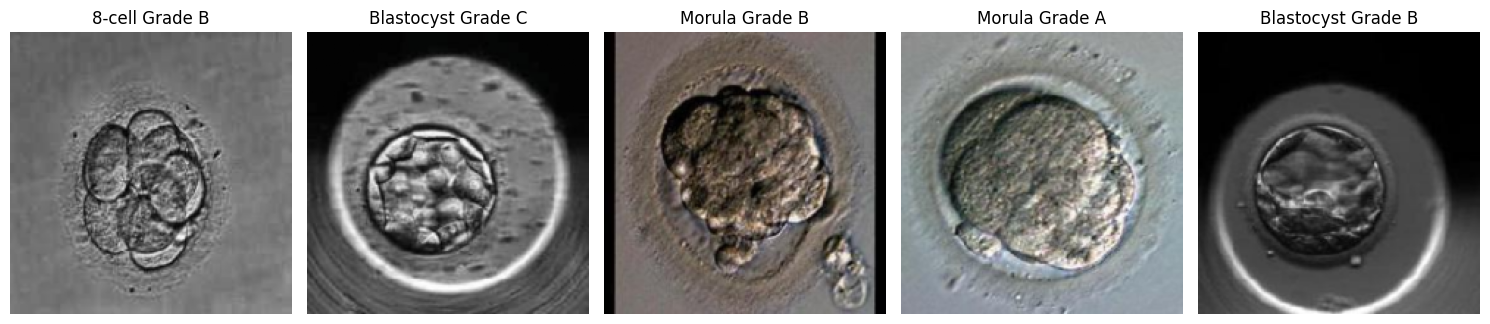

In [12]:
# train data 

dataiter = iter(train_loader)
images, labels = next(dataiter)

class_names = train_dataset.dataset.classes  

plt.figure(figsize=(15, 6))
for i in range(5):
    img = images[i]        
    label = labels[i].item()
    
    img = img.permute(1, 2, 0)  
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

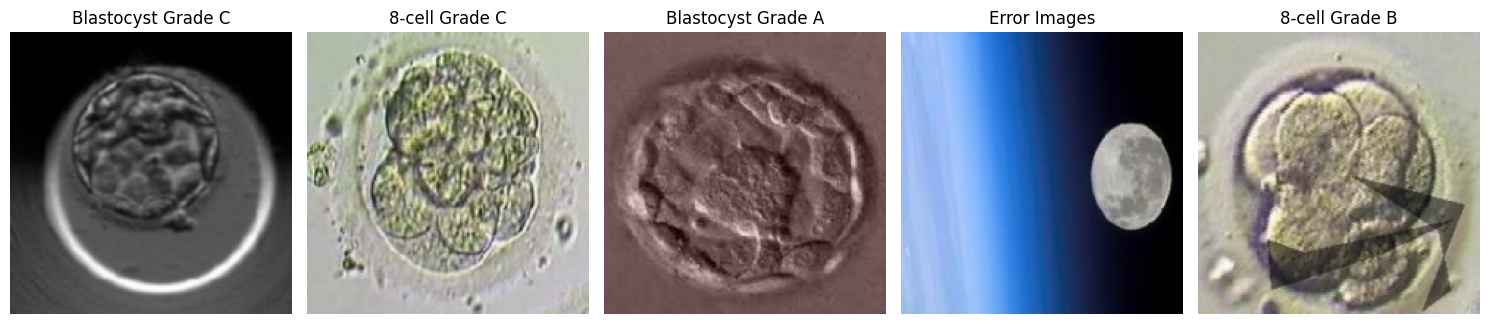

In [13]:
# val data 

dataiter = iter(val_loader)
images, labels = next(dataiter)

class_names = val_dataset.dataset.classes  

plt.figure(figsize=(15, 6))
for i in range(5):
    img = images[i]        
    label = labels[i].item()
    
    img = img.permute(1, 2, 0)  
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Model Phase

In [15]:
# Load Swin Transformer V2

model = timm.create_model('swinv2_base_window12_192_22k', pretrained=True, num_classes=10)
model.to(device)

print("model sucessfully loaded ✅")

model sucessfully loaded ✅


In [16]:
# Loss and Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
# Trackers

train_losses, val_losses = [], []
train_accs, val_accs = [], []

In [19]:
# Early stopping

best_val_loss = float('inf')
patience = 15
wait = 0

In [20]:
# Training Loop

for epoch in range(50):
    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accs.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"\nEpoch {epoch+1}: "
          f"Train Loss={avg_train_loss:.4f}, Train Acc={train_accuracy:.4f}, "
          f"Val Loss={avg_val_loss:.4f}, Val Acc={val_accuracy:.4f}")

    # Early stopping and best model save
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Saved Best Model")
    else:
        wait += 1
        if wait >= patience:
            print("⏹️ Early stopping")
            break

100%|██████████| 243/243 [04:33<00:00,  1.12s/it]



Epoch 1: Train Loss=0.8074, Train Acc=0.6740, Val Loss=0.4299, Val Acc=0.8285
✅ Saved Best Model


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 2: Train Loss=0.2640, Train Acc=0.9054, Val Loss=0.2269, Val Acc=0.9096
✅ Saved Best Model


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 3: Train Loss=0.1400, Train Acc=0.9509, Val Loss=0.3059, Val Acc=0.9143


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 4: Train Loss=0.1182, Train Acc=0.9593, Val Loss=0.2268, Val Acc=0.9282
✅ Saved Best Model


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 5: Train Loss=0.0872, Train Acc=0.9718, Val Loss=0.2230, Val Acc=0.9340
✅ Saved Best Model


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 6: Train Loss=0.0727, Train Acc=0.9769, Val Loss=0.3408, Val Acc=0.9131


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 7: Train Loss=0.0837, Train Acc=0.9742, Val Loss=0.2319, Val Acc=0.9444


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 8: Train Loss=0.0613, Train Acc=0.9807, Val Loss=0.2178, Val Acc=0.9374
✅ Saved Best Model


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 9: Train Loss=0.0633, Train Acc=0.9786, Val Loss=0.4211, Val Acc=0.9003


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 10: Train Loss=0.0822, Train Acc=0.9711, Val Loss=0.2663, Val Acc=0.9305


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 11: Train Loss=0.0488, Train Acc=0.9840, Val Loss=0.2291, Val Acc=0.9305


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 12: Train Loss=0.0535, Train Acc=0.9827, Val Loss=0.2613, Val Acc=0.9374


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 13: Train Loss=0.0539, Train Acc=0.9816, Val Loss=0.2920, Val Acc=0.9316


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 14: Train Loss=0.0477, Train Acc=0.9859, Val Loss=0.3709, Val Acc=0.9166


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 15: Train Loss=0.0537, Train Acc=0.9813, Val Loss=0.2915, Val Acc=0.9397


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 16: Train Loss=0.0377, Train Acc=0.9858, Val Loss=0.3170, Val Acc=0.9479


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 17: Train Loss=0.0486, Train Acc=0.9829, Val Loss=0.3616, Val Acc=0.9224


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 18: Train Loss=0.0644, Train Acc=0.9791, Val Loss=0.2487, Val Acc=0.9363


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 19: Train Loss=0.0406, Train Acc=0.9857, Val Loss=0.3292, Val Acc=0.9189


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 20: Train Loss=0.0376, Train Acc=0.9876, Val Loss=0.2981, Val Acc=0.9328


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 21: Train Loss=0.0468, Train Acc=0.9852, Val Loss=0.2657, Val Acc=0.9363


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 22: Train Loss=0.0600, Train Acc=0.9798, Val Loss=0.3229, Val Acc=0.9340


100%|██████████| 243/243 [04:37<00:00,  1.14s/it]



Epoch 23: Train Loss=0.0407, Train Acc=0.9857, Val Loss=0.3153, Val Acc=0.9363
⏹️ Early stopping


**Train and Validation Loss Plot**

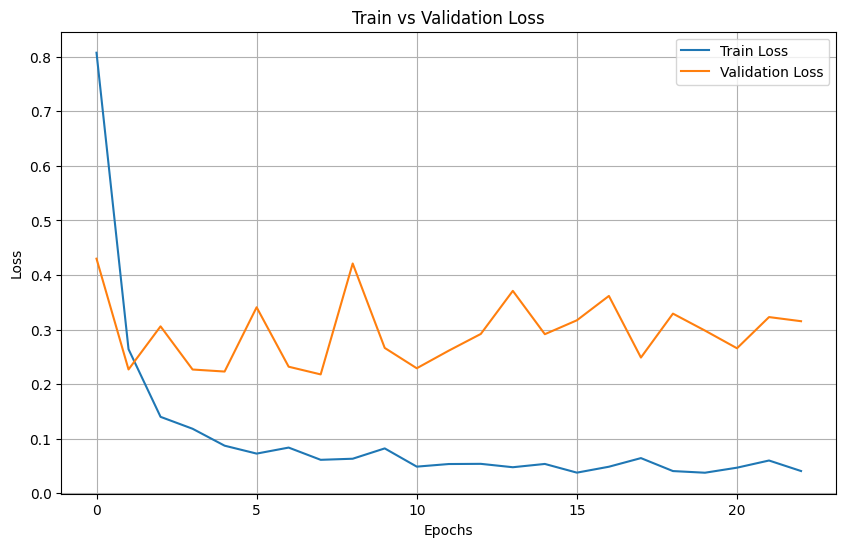

(None,)

In [21]:
# Plotting

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show(), 

**Train and Validation Accuracy Plot**

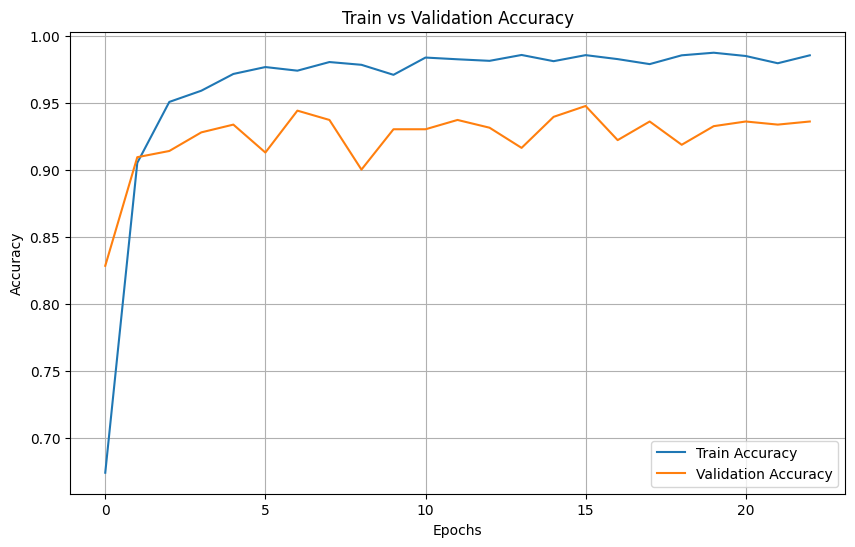

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation 

**Training Dataset**

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Load test set
train_dataset = datasets.ImageFolder(root='/kaggle/working/train/X_train_image', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Evaluate
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
# pip install timm matplotlib scikit-learn
print(f"\n🧪 Test Accuracy: {correct / total:.4f}")


🧪 Test Accuracy: 0.9790


**Test Dataset**

In [24]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Load test set
test_dataset = datasets.ImageFolder(root='/kaggle/working/test/X_test_image', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"\n🧪 Test Accuracy: {correct / total:.4f}")


🧪 Test Accuracy: 0.9311


### 🏷️ Update MLflow Tracking Configuration for Remote 

In [ ]:
from utils.MLFlowTrackingConfig import MLFlowTracking

In [11]:
MLFlowTracking(model, 192, 3, 32, True, 50, 10, 'swinv2_base_window12_192_22k', 1e-4, 0.2178, 0.9790, 0.9311, "swinv2_base_window12_192_22k")

Accessing as revanth-kumar-01-ai

Initialized MLflow to track repo "revanth-kumar-01-ai/360DigitMG-Training-Phase"

Repository revanth-kumar-01-ai/360DigitMG-Training-Phase initialized!

2025/04/23 12:02:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'swinv2_base_window12_192_22k'.
2025/04/23 12:04:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: swinv2_base_window12_192_22k, version 1
Created version '1' of model 'swinv2_base_window12_192_22k'.


🏃 View run overjoyed-bear-66 at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0/runs/b7f347db219541c09b70249a1ad903ac
🧪 View experiment at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0
✅ MLflow tracking logged successfully! 🚀
